#  How to perform functional enrichment analysis on Chip-Seq data?
# Test the enrichment of some functional categories close to topoisomerase I peaks

Please use the next cell to adjust the two following variables according to your installation: 
- path to GRATIOSA package
- path to database

In [1]:
import sys
## PATH TO PACKAGE:
## ----------------
## IF ALREADY IN YOUR PYTHON PATH (e.g. installation through Pip): nothing to do
## IF NOT IN YOUR PYTHON PATH (e.g. download from GitHub): 
## uncomment and adjust the following relevant line to the location of the GRATIOSA directory
## - For Linux/MacOS:             typical style ;-)
#sys.path.append('/home/usr/Python_venv/lib/python3.8/site-packages/') 
# sys.path.insert(0,"/home/s/Téléchargements/GRATIOSA-master/")
#sys.path.append("/home/s/Downloads/GRATIOSA-master/")
## (- For Windows:                  typical style ;-)
#sys.path.append('C:\\Downloads\\GRATIOSA-master')


import os
## PATH TO DATABASE:
## -----------------
## FOR REGULAR USE OF THE PACKAGE:
#  Please set your system environment variable \$GRATIOSA_DB_PATH in order to have 
#  \$GRATIOSA_DB_PATH + data/organisms (e.g. export GRATIOSA_DB_PATH=/home/usr/documents/GRATIOSA/).
## FOR THIS TUTORIAL ONLY:
#  you can skip the system environment variable and just use the following line
#  We assume that the "data" directory containing the database is in the parent directory (otherwise adjust line)
os.environ["GRATIOSA_DB_PATH"]=os.getcwd()+"/../"
print("Please check that the database is stored in: %s"%(os.environ["GRATIOSA_DB_PATH"]))

Please check that the database is stored in: /home/s/maiwenn_PhD/article_GRATIOSA/test_GRATIOSA/GRATIOSA-master/tutorials/../


In [1]:
# Loading the modules for data loading
from GRATIOSA import Genome, Chipseq, GO

# Loading the statistical analysis and graphic modules
from GRATIOSA import stat_analysis, plot_stat_analysis
import numpy as np

## 1 - Data loading
#### Genomic annotation loading

In [2]:
g = Genome.Genome("ecoli_W3110_Mu")
g.load_seq()
g.load_annotation()

Detected a genome with 1 chromosome
Chromosome NC_007779.1_w3110_Mu of length 4647454
Sequence of organism ecoli_W3110_Mu loaded
Trying to load annotation from: /home/s/topo_data/data/ecoli_W3110_Mu/annotation/sequence.gff3
Annotation of ecoli_W3110_Mu loaded
Number of genes: 4312


#### ChipSeq signal loading for topoisomerase I

In [3]:
# Initialization of the Chipseq object
ch = Chipseq.Chipseq(g)

# Selection of replicates 
cond =["Sutormin_TopoI_R1", "Sutormin_TopoI_R2", "Sutormin_TopoI_R3"]

# The load_signal_average method performs the following two steps:
# 1 - Processes each replicate (here, binning with a chosen binsize)
# 2 - Calculates the average signal between replicates for each genomic position, to reduce noise
binsize = 100  # Choice of the binsize (in b) for the binning
cond_name = f"Topo_bin{binsize}b" # Choice of the new signal name
ch.load_signals_average(list_cond=cond,  # automatic computation of average between the chosen list of samples
                        average_name=cond_name,
                        data_treatment="binning",
                        binsize=binsize)
signal_per_bin = ch.signals_average[cond_name][np.arange(0,g.length,binsize)]  # for facility, give a simple name

loading the file obtained with the following parameters:

Name: Topo_bin100b

 Replicates: ['Sutormin_TopoI_R1', 'Sutormin_TopoI_R2', 'Sutormin_TopoI_R3']

 Data treatment: binning

 Size (window or bin, in b): 100

Please change 'average_name' to use other signals


## 2 - Simplified peak calling and gene selection

#### Selection of bins with strongest topoisomerase binding signal using the built-in data classification function

In [4]:
nb_peaks = 100 # Choice of the number of strong peaks to keep as a separate class 

# Use an automatic function to classify ChIP-Seq bins into classes according to binding strength, with chosen size
# Here, only two classes: [0] almost all bins; [1] 100 strongest bins
peaks_bin = stat_analysis.data_classification(np.arange(len(signal_per_bin)),
                                              signal_per_bin,
                                              class_nb = 2, 
                                              class_sizes = [len(signal_per_bin)-nb_peaks,nb_peaks]
                                             )[0][1]

0: 46375 elements
1: 100 elements


#### Gene selection (2 options):
+ A: Selection of genes within a chosen window size around each enriched bin

In [5]:
ws = 400 #Choice of the window size ws (in b). 

#Genes located between the start of the peak - ws and the end of the peak + ws are selected
g.load_genes_per_pos(ws*2+binsize)

peak_genes = []
for i in peaks_bin :
    genes = g.genes_per_pos[i*binsize]
    if genes != [None] : 
        peak_genes.extend(genes)
peak_genes =  list(dict.fromkeys(peak_genes))
nopeak_genes = [i for i in list(g.genes.keys()) if i not in peak_genes]

Operation genes_per_pos completed for genome ecoli_W3110_Mu


+ B: Selection of the 2 closest genes to each enriched bin

In [6]:
g.load_neighbor_all() #Load, for each position, the closest right and left neighbors

neighbor_genes = []
for i in peaks_bin :
    neighbor_genes.extend([g.left_neighbor[i*binsize],g.right_neighbor[i*binsize]])
neighbor_genes =  list(dict.fromkeys(neighbor_genes))
notneighbor_genes = [i for i in list(g.genes.keys()) if i not in neighbor_genes]

Operation load_neighbor_all completed for genome ecoli_W3110_Mu


## 3 - Functional enrichment analysis (GO annotation)

#### GO annotation loading

In [7]:
g.load_GO()
dict_GO = g.GO['GO']

Loading GO...
	3734 genes were successfully associated with some GO terms
	578 genes were not associated with any GO term


#### Functional enrichment analysis

In [8]:
genes = {"Peak" : peak_genes, "No peak" : nopeak_genes}  # gene selection made with option A
# genes = {"Peak" : neighbor_genes, "No peak" : notneighbor_genes} # gene selection made with option B

# Performs enrichment analysis
# On first execution, the function automatically downloads the updated GO descriptor file .obo from the Gene Ontology website
# Exports 3 csv files (GOc, GOp, GOf), with enrichment test for each function. 
GO.GO_enrichment_test(dict_GO,genes,"Peak",obo_reload=True,
                      output_file=f"GO_enrichment_bin{binsize}b_{nb_peaks}peaks")

--2024-04-16 16:25:42--  http://purl.obolibrary.org/obo/go/go-basic.obo
Resolving purl.obolibrary.org (purl.obolibrary.org)... 104.18.37.59, 172.64.150.197, 2606:4700:4400::6812:253b, ...
Connecting to purl.obolibrary.org (purl.obolibrary.org)|104.18.37.59|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://current.geneontology.org/ontology/go-basic.obo [following]
--2024-04-16 16:25:43--  http://current.geneontology.org/ontology/go-basic.obo
Resolving current.geneontology.org (current.geneontology.org)... 18.238.4.127, 18.238.4.17, 18.238.4.40, ...
Connecting to current.geneontology.org (current.geneontology.org)|18.238.4.127|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31267219 (30M) [text/obo]
Saving to: ‘/home/s/topo_data/data/go-basic.obo.1’

     0K .......... .......... .......... .......... ..........  0%  156K 3m15s
    50K .......... .......... .......... .......... ..........  0% 2,37M 1m44s
   100K .......... ....

  5200K .......... .......... .......... .......... .......... 17% 4,68M 6s
  5250K .......... .......... .......... .......... .......... 17% 3,41M 6s
  5300K .......... .......... .......... .......... .......... 17%  186M 6s
  5350K .......... .......... .......... .......... .......... 17% 4,54M 6s
  5400K .......... .......... .......... .......... .......... 17% 8,70M 6s
  5450K .......... .......... .......... .......... .......... 18%  336M 6s
  5500K .......... .......... .......... .......... .......... 18%  342M 6s
  5550K .......... .......... .......... .......... .......... 18% 9,76M 6s
  5600K .......... .......... .......... .......... .......... 18%  341M 6s
  5650K .......... .......... .......... .......... .......... 18% 4,25M 6s
  5700K .......... .......... .......... .......... .......... 18%  304M 6s
  5750K .......... .......... .......... .......... .......... 18%  386M 6s
  5800K .......... .......... .......... .......... .......... 19% 2,15M 6s
  5850K ....

 10900K .......... .......... .......... .......... .......... 35% 1,25M 5s
 10950K .......... .......... .......... .......... .......... 36% 1,06M 5s
 11000K .......... .......... .......... .......... .......... 36% 2,50M 5s
 11050K .......... .......... .......... .......... .......... 36%  763K 5s
 11100K .......... .......... .......... .......... .......... 36% 7,51M 5s
 11150K .......... .......... .......... .......... .......... 36% 15,6M 5s
 11200K .......... .......... .......... .......... .......... 36% 7,64M 5s
 11250K .......... .......... .......... .......... .......... 37% 14,5M 5s
 11300K .......... .......... .......... .......... .......... 37% 3,72M 5s
 11350K .......... .......... .......... .......... .......... 37% 5,04M 5s
 11400K .......... .......... .......... .......... .......... 37% 7,48M 5s
 11450K .......... .......... .......... .......... .......... 37% 7,32M 5s
 11500K .......... .......... .......... .......... .......... 37% 7,61M 5s
 11550K ....

 16900K .......... .......... .......... .......... .......... 55% 3,81M 3s
 16950K .......... .......... .......... .......... .......... 55%  262M 3s
 17000K .......... .......... .......... .......... .......... 55%  387M 3s
 17050K .......... .......... .......... .......... .......... 56% 15,9M 3s
 17100K .......... .......... .......... .......... .......... 56% 16,3M 3s
 17150K .......... .......... .......... .......... .......... 56% 7,52M 3s
 17200K .......... .......... .......... .......... .......... 56% 14,6M 3s
 17250K .......... .......... .......... .......... .......... 56% 7,50M 3s
 17300K .......... .......... .......... .......... .......... 56%  297M 3s
 17350K .......... .......... .......... .......... .......... 56% 7,60M 3s
 17400K .......... .......... .......... .......... .......... 57% 7,56M 3s
 17450K .......... .......... .......... .......... .......... 57% 14,5M 3s
 17500K .......... .......... .......... .......... .......... 57% 14,9M 3s
 17550K ....

 23850K .......... .......... .......... .......... .......... 78% 7,46M 1s
 23900K .......... .......... .......... .......... .......... 78%  368M 1s
 23950K .......... .......... .......... .......... .......... 78%  387M 1s
 24000K .......... .......... .......... .......... .......... 78% 16,6M 1s
 24050K .......... .......... .......... .......... .......... 78% 3,74M 1s
 24100K .......... .......... .......... .......... .......... 79%  220M 1s
 24150K .......... .......... .......... .......... .......... 79% 5,13M 1s
 24200K .......... .......... .......... .......... .......... 79% 14,6M 1s
 24250K .......... .......... .......... .......... .......... 79% 14,1M 1s
 24300K .......... .......... .......... .......... .......... 79% 16,7M 1s
 24350K .......... .......... .......... .......... .......... 79% 14,9M 1s
 24400K .......... .......... .......... .......... .......... 80%  260M 1s
 24450K .......... .......... .......... .......... .......... 80% 15,5M 1s
 24500K ....

 30100K .......... .......... .......... .......... .......... 98% 3,01M 0s
 30150K .......... .......... .......... .......... .......... 98% 3,74M 0s
 30200K .......... .......... .......... .......... .......... 99% 14,9M 0s
 30250K .......... .......... .......... .......... .......... 99% 7,54M 0s
 30300K .......... .......... .......... .......... .......... 99% 1,86M 0s
 30350K .......... .......... .......... .......... .......... 99% 2,49M 0s
 30400K .......... .......... .......... .......... .......... 99% 4,95M 0s
 30450K .......... .......... .......... .......... .......... 99% 2,94M 0s
 30500K .......... .......... .......... ....                 100% 2,11M=4,9s

2024-04-16 16:25:49 (6,12 MB/s) - ‘/home/s/topo_data/data/go-basic.obo.1’ saved [31267219/31267219]



Results saved in /home/s/topo_data/resdir/enrichment_test/GO_enrichment_bin100b_100peaks_GOc.csv
Results saved in /home/s/topo_data/resdir/enrichment_test/GO_enrichment_bin100b_100peaks_GOp.csv
Results saved in /home/s/topo_data/resdir/enrichment_test/GO_enrichment_bin100b_100peaks_GOf.csv
Results saved in /home/s/topo_data/resdir/enrichment_test/GO_enrichment_bin100b_100peaks_significant.csv


#### Visualization of some enrichment results

GO:0009103: 56 valid elements
GO:0045226: 12 valid elements
GO:0015774: 5 valid elements
Results saved in /home/s/topo_data/resdir/enrichment_test/test1.csv
     Category  Selected_gene_nb  Expected_selected_nb  Adj p-value (FDR)
0  GO:0009103                 9              0.779861       1.326920e-07
1  GO:0045226                 0              0.167113       1.000000e+00
2  GO:0015774                 0              0.069630       1.000000e+00
     Category  Selected_gene_nb  Total_gene_nb  Proportion     Prop_conf_int  \
0  GO:0009103                 9             56    0.160714  [0.1339, 0.1875]   
1  GO:0045226                 0             12    0.000000     [0.0, 0.0417]   
2  GO:0015774                 0              5    0.000000        [0.0, 0.1]   

        p-value  Adj p-value (FDR)  Global_proportion  Expected_selected_nb  
0  4.423067e-08       1.326920e-07           0.013926              0.779861  
1  1.000000e+00       1.000000e+00           0.013926              0.16711

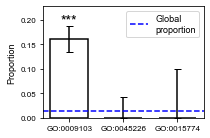

In [9]:
# Plot the proportion of genes of different GO terms, which belong to the selected group 
# (here close to high topoisomerase I peaks)
# and perform an enrichment test to compare it to the genomic average (here around 0.02%)
plot_stat_analysis.plot_enrichment_test(
    dict_GO,genes,
    targ_features=["Peak"],
    targ_cats=["GO:0009103","GO:0045226","GO:0015774"],
    figsize = (3,2),
    output_file="test1")

In [ ]:
# A strong and significant enrichment is observed for the term GO:0009103, "lipopolysaccharide biosynthetic process"